# Assignment 2 - Used Car Price Prediction
Sapir Elad - 322612706

Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

Load dataset & diaplay info

In [ ]:
df = pd.read_csv("car_web_scraped_dataset.csv")

In [ ]:
# Display dataset info
df.info()
print("\nSummary Statistics:\n", df.describe())
print("\nFirst Few Rows:\n", df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840 entries, 0 to 2839
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       2840 non-null   object
 1   year       2840 non-null   int64 
 2   miles      2840 non-null   object
 3   color      2840 non-null   object
 4   condition  2840 non-null   object
 5   price      2840 non-null   object
dtypes: int64(1), object(5)
memory usage: 133.3+ KB

Summary Statistics:
               year
count  2840.000000
mean   2018.833803
std       3.557585
min    2000.000000
25%    2017.000000
50%    2020.000000
75%    2021.000000
max    2024.000000

First Few Rows:
                        name  year         miles  \
0                 Kia Forte  2022  41,406 miles   
1  Chevrolet Silverado 1500  2021  15,138 miles   
2               Toyota RAV4  2022  32,879 miles   
3               Honda Civic  2020  37,190 miles   
4               Honda Civic  2020  27,496 miles   

            

This dataset contains details about used cars, including their year, mileage, condition, ownership, and price. The cars range from 2000 to 2024, with most being from 2018 or newer. Some newer cars have high mileage, while some older ones have low mileage.

Prices range, depending on mileage, condition, and brand. Some cars have accidents reported, while others are accident-free. Most have one owner.

This data can help analyze how mileage, accident history, and ownership affect car prices, making it useful for predicting used car values.

### Step 1: Data Cleaning & Feature Engineering

In [ ]:
# Convert 'miles' and 'price' to numeric values
df['miles'] = df['miles'].str.replace(',', '').str.replace(' miles', '').astype(float)
df['price'] = df['price'].str.replace(r'[$,]', '', regex=True).astype(float)

# Extract 'exterior_color' and 'interior_color'
df[['exterior_color', 'interior_color']] = df['color'].str.extract(r'(.+) exterior, (.+) interior')
df.drop(columns=['color'], inplace=True)

# Extract 'accidents_reported' and 'num_owners'
df['accidents_reported'] = df['condition'].str.contains('No accidents reported').astype(int)
df['num_owners'] = df['condition'].str.extract(r'(\d+) Owner').astype(float).fillna(0).astype(int)
df.drop(columns=['condition'], inplace=True)

# Create a 'miles_per_year' feature with log transformation
current_year = 2024
df['miles_per_year'] = df['miles'] / (current_year - df['year'] + 1)
df['miles_per_year'] = np.clip(df['miles_per_year'], 0, df['miles_per_year'].quantile(0.99))

# Log transformation of price
df['log_price'] = np.log1p(df['price'])

* Converted miles and price to numeric values for analysis.
* Split color into exterior and interior colors.
* Extracted accident history (1 = no accidents, 0 = accidents reported) and number of owners.
* Created miles per year, capping extreme values.
* Applied log transformation to price for better distribution.

### Step 2: Outlier Detection and Handling

In [ ]:
# Winsorization of price
lower_limit = df['price'].quantile(0.01)
upper_limit = df['price'].quantile(0.99)
df['price'] = np.clip(df['price'], lower_limit, upper_limit)

* Winsorization is applied to limit extreme price values.
The lower 1% and upper 1% of prices are capped at the 1st and 99th percentiles.
* This helps reduce the impact of outliers, making the model more stable and less sensitive to extreme values.

### Step 3: Data Analysis & Visualization


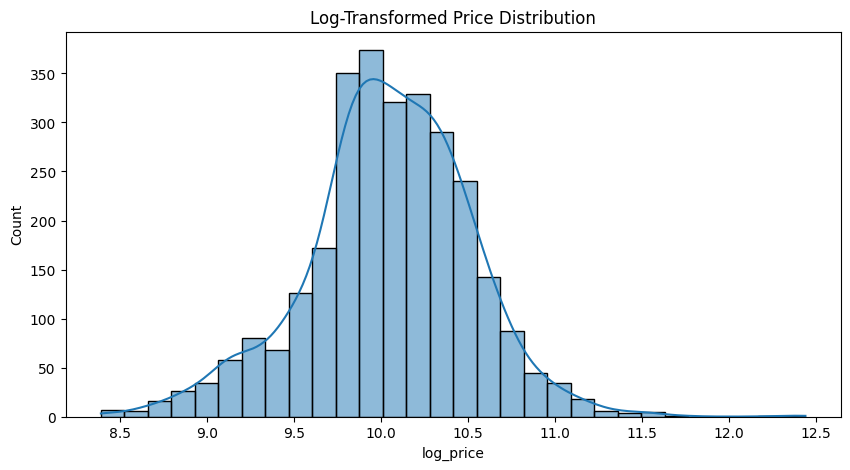

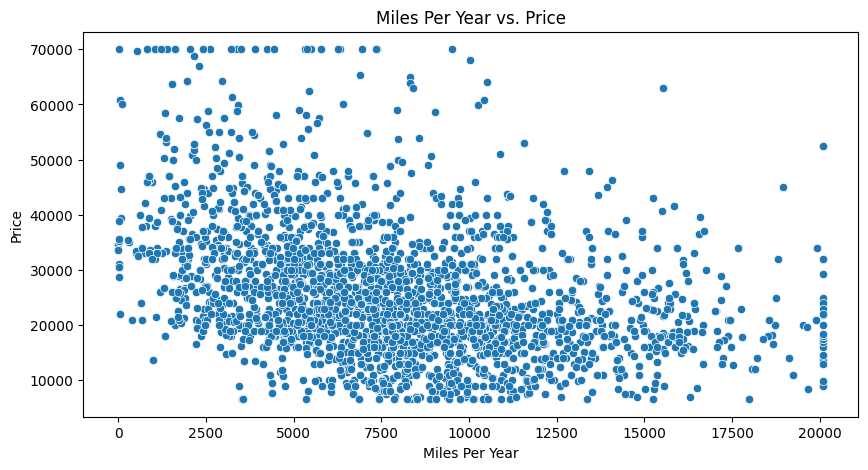

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['log_price'], bins=30, kde=True)
plt.title('Log-Transformed Price Distribution')
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['miles_per_year'], y=df['price'])
plt.title('Miles Per Year vs. Price')
plt.xlabel('Miles Per Year')
plt.ylabel('Price')
plt.show()


Visualization Insights
* **1) Log-Transformed Price Distribution**:
The log-transformed price follows a more normal distribution, reducing skewness in the original price data.
This transformation helps models better capture relationships between price and other variables.

* **2) Miles Per Year vs. Price**:
The scatter plot shows a negative correlation between miles per year and price—higher mileage generally leads to lower prices.
However, there is high variance, meaning other factors (brand, condition, accidents) also impact pricing.
Some high-priced cars have high mileage, possibly indicating luxury or newer models that retain value.

### Step 4: Model Training

In [ ]:
for cat in categorical_features:
    mean_encoded = df.groupby(cat)['log_price'].mean()
    df[cat] = df[cat].map(mean_encoded)
    df[cat] = df[cat].fillna(df[cat].mean())
categorical_features = ['exterior_color', 'interior_color', 'year']  # Added 'year' back for better predictions
for cat in categorical_features:
    mean_encoded = df.groupby(cat)['log_price'].mean()
    df[cat] = df[cat].map(mean_encoded)

# Splitting dataset (80% train, 10% validation, 10% test)
X = df.drop(columns=['price', 'log_price', 'name'])
X['miles_num_owners'] = df['miles_per_year'] * df['num_owners']
X['year_miles'] = df['year'] * df['miles_per_year']
y = df['log_price']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train models
# Optimized hyperparameters for better generalization
models = {
    "Random Forest": RandomForestRegressor(n_estimators=180, max_depth=15, min_samples_split=10, min_samples_leaf=6, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=180, max_depth=6, learning_rate=0.03, subsample=0.9, colsample_bytree=0.9, eval_metric='rmse', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    results[name] = {
        "Train MAE": mean_absolute_error(y_train, model.predict(X_train)),
        "Validation MAE": mean_absolute_error(y_val, model.predict(X_val)),
        "Test MAE": mean_absolute_error(y_test, model.predict(X_test)),
        "Train R2": r2_score(y_train, model.predict(X_train)),
        "Validation R2": r2_score(y_val, model.predict(X_val)),
        "Test R2": r2_score(y_test, model.predict(X_test))
    }


results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:\n")
print(results_df)



Model Performance Comparison:

               Train MAE  Validation MAE  Test MAE  Train R2  Validation R2  \
Random Forest   0.181692        0.225643  0.238190  0.741772       0.618162   
XGBoost         0.177889        0.221759  0.238125  0.759609       0.629748   

                Test R2  
Random Forest  0.621385  
XGBoost        0.624796  


* **Categorical** **Features**: Used mean encoding for exterior color, interior color, and year to improve predictions.
* **Feature Engineering**: Created miles_num_owners and year_miles to capture usage and aging effects.
* **Data Splitting & Scaling**: 80% train, 10% validation, 10% test, with standardization for consistency.
* **Model Training**: Trained Random Forest and XGBoost with optimized hyperparameters.
* **Performance**:
XGBoost performed best, with lower MAE (0.2218 validation, 0.2381 test) and higher R² (0.6297 validation, 0.6248 test).
Random Forest showed slight overfitting but still performed well.
Conclusion: XGBoost is the preferred model for predicting used car prices.